In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../dataset/data0test.txt'
data0Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

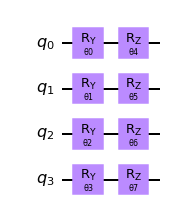

In [6]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;

feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

ansatz.draw('mpl')

# Example Optimzizer LBFGS

## Learning Rate = 4

In [14]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=4,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

70.26908874511719
69.60505676269531
68.6187744140625
83.77739715576172
73.47237396240234
76.14546203613281
66.13320922851562
79.78182220458984
69.23707580566406
78.16270446777344
66.01258850097656
73.77827453613281
68.96382141113281
69.45221710205078
72.05654907226562
77.33241271972656
70.19990539550781
69.9831771850586
68.93885803222656
70.21707153320312
63.18802261352539
74.79623413085938
65.31674194335938
70.80640411376953
72.12594604492188
71.5768814086914
71.53643035888672
75.26360321044922
76.36466217041016
75.13294982910156
75.35393524169922
67.43299865722656
71.79248046875
72.84706115722656
72.90746307373047
71.17062377929688
73.21625518798828
66.19194793701172
71.00001525878906
70.55672454833984
72.5759048461914
80.21772003173828
75.86075592041016
75.46522521972656


tensor(70.2691, grad_fn=<AddBackward0>)

Accuracy: 0.28


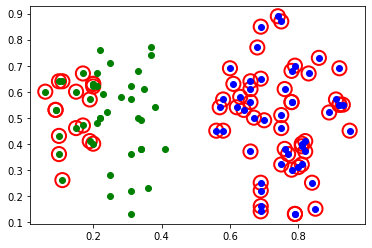

In [15]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

## Learning Rate = 2

In [12]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=2,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

69.28602600097656
67.86192321777344
66.80635833740234
68.84136962890625
70.1138687133789
67.92646026611328
63.73554992675781
65.19754028320312
64.94815826416016
65.13017272949219
64.84935760498047
65.28731536865234
64.78697204589844
69.53990936279297
68.26853942871094
64.43551635742188
68.32432556152344
67.86128234863281
65.90052032470703
67.71603393554688


tensor(69.2860, grad_fn=<AddBackward0>)

Accuracy: 0.41


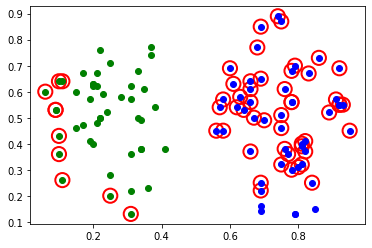

In [13]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

## Learning Rate =1(default)

In [7]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [8]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

69.83106231689453
66.20822143554688
64.93342590332031
63.794593811035156
65.66104125976562
62.9725341796875
62.96023941040039
62.95855712890625
62.958526611328125
62.958534240722656


tensor(69.8311, grad_fn=<AddBackward0>)

Accuracy: 0.68


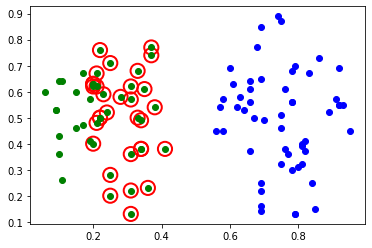

In [9]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

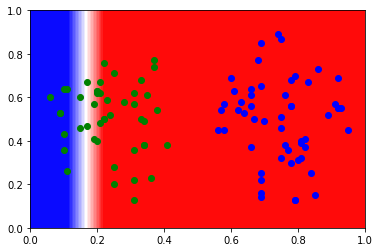

In [10]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=10)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

## Learning Rate = 0.5

In [16]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=0.5,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

69.62196350097656
67.22303771972656
65.66899108886719
64.87419891357422
64.59135437011719
63.58671569824219
63.384151458740234
63.0422477722168
62.978515625
62.963592529296875
62.959815979003906
62.9588623046875
62.958621978759766
62.95855712890625
62.95854187011719
62.958526611328125
62.958553314208984
62.958553314208984


tensor(69.6220, grad_fn=<AddBackward0>)

Accuracy: 0.68


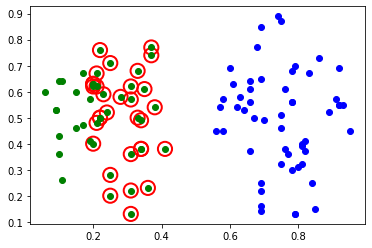

In [17]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

## Learning Rate = 0.1

In [7]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=0.1,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

69.83106231689453
69.08914947509766
68.05722045898438
65.70301818847656
65.11924743652344
64.87215423583984
64.6701889038086
64.49303436279297
64.3378677368164
64.20059967041016
64.0770492553711
63.963645935058594
63.85768127441406
63.757286071777344
63.66127014160156
63.5693359375
63.4819221496582
63.400081634521484
63.32535171508789
63.25917434692383
63.20241928100586
63.15507507324219
63.116397857666016
63.08515548706055
63.06010437011719
63.040061950683594
63.024017333984375
63.011192321777344
63.000911712646484
62.99267578125
62.986045837402344
62.9807243347168
62.976463317871094
62.972991943359375
62.97022247314453
62.96796798706055
62.96616744995117
62.964691162109375
62.96352767944336
62.96255874633789
62.9618034362793
62.961185455322266
62.96066665649414
62.96027374267578
62.95992660522461
62.95967483520508
62.95945358276367
62.95928192138672
62.95913314819336
62.95903015136719
62.958919525146484
62.95885467529297
62.95878982543945
62.9587516784668
62.95868682861328
62.9586791

tensor(69.8311, grad_fn=<AddBackward0>)

Accuracy: 0.68


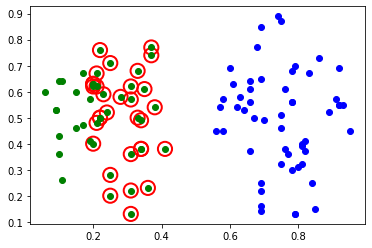

In [8]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

## Learning Rate = 0.05

In [ ]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=0.05,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

69.28602600097656
68.89596557617188
68.24604797363281
66.24053192138672
65.66122436523438
65.40155029296875
65.18489074707031
64.99109649658203
64.81926727294922
64.6675796508789
64.53328704833984
64.41365051269531
64.30635833740234
64.20940399169922
64.12118530273438
64.04039764404297
63.965946197509766
63.89701843261719
63.83284378051758
63.77284622192383
63.716552734375
63.66355895996094
63.61354446411133
63.56627655029297
63.52151870727539
63.479129791259766
63.43901062011719
63.40104293823242
63.365211486816406


In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

## Learning Rate = 0.01

In [ ]:
parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = LBFGS(model2.parameters(),lr=0.01,max_iter=100)
f_loss = CrossEntropyLoss()

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

In [ ]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()